In [2]:
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers/UI
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers


## only depth

In [4]:
# from share import *
# import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt

onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"

def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth
################################


def show_image(img, detect_resolution=512):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    input_image_np = img

    rgb_image =resize_image(input_image_np, detect_resolution)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    return tiff_np_uint8,tiff_pil_uint8


inputs_np=gr.Image(type="numpy")


demo = gr.Interface(
    fn=show_image, 
    inputs=gr.Image(type="numpy"), 
    outputs=[gr.Image(type="numpy"),
             gr.Image(type="pil"),
            ]
)
    
# demo.launch(share=True)
demo.launch()

ModuleNotFoundError: No module named 'annotator'

## depth + corrosion

In [5]:
# from share import *
# import config
import imgviz
import os
# 查看当前工作目录
retval = os.getcwd()
print("当前工作目录为 %s" % retval)
os.chdir('/home/ubunto/Project/konglx/generate/diffusers')

# 查看修改后的工作目录
retval = os.getcwd()

print("目录修改成功 %s" % retval)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

# from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
# from cldm.model import create_model, load_state_dict
# from cldm.ddim_hacked import DDIMSampler
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler, DDPMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image


from torchvision import transforms
from PIL import Image
import tqdm
import PIL

######################
# rough深度的onnx推理准备
import onnxruntime as ort

import cv2
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt

onnx_model_dir="/home/ubunto/Project/konglx/mono_depth/Metric3D-main/onnx/metric3d-vit-small/onnx/model.onnx"

def prepare_input(
    rgb_image: np.ndarray, input_size: Tuple[int, int]
) -> Tuple[Dict[str, np.ndarray], List[int]]:

    h, w = rgb_image.shape[:2] # 原图尺寸
    scale = min(input_size[0] / h, input_size[1] / w)
    rgb = cv2.resize(
        rgb_image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR
    )

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2  # h方向，每边padding的尺寸
    pad_w_half = pad_w // 2  # w方向，每边padding的尺寸
    rgb: np.ndarray = cv2.copyMakeBorder(
        rgb,
        pad_h_half,
        pad_h - pad_h_half,
        pad_w_half,
        pad_w - pad_w_half,
        cv2.BORDER_CONSTANT,
        value=padding,
    )
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]

    onnx_input = {
        # "image": np.ascontiguousarray(
        "pixel_values": np.ascontiguousarray(
            np.transpose(rgb, (2, 0, 1))[None], dtype=np.float32
        ),  # 1, 3, H, W
    }
    return onnx_input, pad_info

def onnx_inference(onnx_model_dir: str, input_image: np):

    ## Dummy Test
    B = 1
    if "vit" in onnx_model_dir:
        input_size = (616, 1064)  # [H, W]
        if 'fp16' in onnx_model_dir:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float16)
        else:
            dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)
    else:
        input_size = (544, 1216)  # [H, W]
        dummy_image = np.zeros([B, 3, input_size[0], input_size[1]], dtype=np.float32)

    providers = [
        (
            "CUDAExecutionProvider",
            {"cudnn_conv_use_max_workspace": "0", "device_id": str(0)},
        )
    ]
    # providers = [("TensorrtExecutionProvider", {'trt_engine_cache_enable': True, 'trt_fp16_enable': True, 'device_id': 0, 'trt_dla_enable': False})]
    ort_session = ort.InferenceSession(onnx_model_dir, providers=providers)

    input_name = ort_session.get_inputs()[0].name
    out_name = ort_session.get_outputs()[0].name
    print(input_name, out_name, sep='\n')
    # outputs = ort_session.run(None, {"image": dummy_image})
    outputs = ort_session.run(None, {input_name: dummy_image})

    print(
        f"The actual output of onnxruntime session for the dummy set: outputs[0].shape={outputs[0].shape}"
    )
    # input_iamge = input_image
    # print(np.unique(input_image))

    original_shape = input_image.shape[:2]
    onnx_input, pad_info = prepare_input(input_image, input_size)  # rgb_image是原图形状[512,512], input_size = (616, 1064)
    outputs = ort_session.run(None, onnx_input)
    depth = outputs[0].squeeze()  # [H, W]
    # plt.imshow(depth)
    # Reshape the depth to the original size
    depth = depth[
        pad_info[0] : input_size[0] - pad_info[1],
        pad_info[2] : input_size[1] - pad_info[3],
    ]
    depth = cv2.resize(
        depth, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR
    )
    return depth
################################

######################
#  controlnet模型准备
def controlnet_diff(corrosion_with_bg_pil, mask_depth_pil, prompt = '',device = 'cuda',seed = 2024,use_freeu = False,controlnet_conditioning_scale_list=[1.0,1.0],
                    config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5',
                    control_corrosion_with_bg_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_with_background_merge_inpainting_h-512_w-512_2024-07-29_13:19:18_seeds-2024/checkpoint-5700/controlnet',
                    control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet',
                    scheduler_select = 'PSNR',
                    inference_steps=20,
                    guidance_scale=7.5,
                    ):
    with torch.no_grad():
        print('scheduler_select:', scheduler_select)
        controlnet_corrosion_with_bg = ControlNetModel.from_pretrained(control_corrosion_with_bg_trained_dir)
        controlnet_depth = ControlNetModel.from_pretrained(control_depth_trained_dir)
        if scheduler_select == 'PSNR' or scheduler_select == None:
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None).to(device)
        elif scheduler_select == 'DDPM':
            # scheduler DDPM
            scheduler = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        elif scheduler_select == 'DDIM':
            # scheduler DDIM
            scheduler = DDIMScheduler.from_pretrained(config_dir, subfolder="scheduler")
            pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler).to(device)
        generator = torch.Generator(device=device).manual_seed(seed)

        pipeline.unet.use_freeu = use_freeu 
        

        mask_corrosion_with_bg_pil = load_image(corrosion_with_bg_pil)
        mask_depth_pil = load_image(mask_depth_pil)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=inference_steps, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list,
                        guidance_scale=guidance_scale,
                            ).images[0]
    torch.cuda.empty_cache()
    return image
#######################

################################
# gradio的功能接口定义
def show_image(org_img, img, prompt='', image_resolution=512, scheduler_select='PSNR',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img
    org_rgb_image =resize_image(org_img, image_resolution)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil


def show_image_draw(org_img, img, prompt='', image_resolution=512, scheduler_select='PSNR',
               inference_steps=20, guidance_scale=7.5,seed=2024):

    # Convert To PIL Image
    # image = Image.open(img)
    # print(type(image))

    # # Convert the image to a NumPy array
    # image_array = np.array(image)
    # print(type(image_array))
    # input_image_np = (img.astype(np.float32) / 255.0) * 2 - 1
    # print('scheduler_select:', scheduler_select)
    input_image_np = img['composite']
    org_rgb_image =resize_image(org_img, image_resolution)
    rgb_image =resize_image(input_image_np, image_resolution)
    rgb_image_pil = Image.fromarray(rgb_image)
    tiff_np = onnx_inference(onnx_model_dir=onnx_model_dir, input_image=org_rgb_image)
    vmin = np.percentile(tiff_np, 2)
    vmax = np.percentile(tiff_np, 85)
    # print(vmin, vmax)

    tiff_np -= vmin
    tiff_np /= vmax - vmin
    tiff_np = 1.0 - tiff_np
    tiff_np_uint8 = (tiff_np * 255.0).clip(0, 255).astype(np.uint8)
    tiff_pil_uint8 = Image.fromarray(tiff_np_uint8)
    # print(np.unique(tiff_np_uint8))
    # print(type(tiff_np_uint8))

    out_control_diff_pil = controlnet_diff(corrosion_with_bg_pil=rgb_image_pil, mask_depth_pil=tiff_pil_uint8, 
                                           prompt=prompt,scheduler_select=scheduler_select, 
                                           inference_steps=inference_steps, guidance_scale=guidance_scale,
                                           seed=seed,)
    
    return [tiff_pil_uint8,out_control_diff_pil]
    # return tiff_pil_uint8,out_control_diff_pil

# 绘图
def create_canvas(w, h):
    return np.zeros(shape=(h, w, 3), dtype=np.uint8)



brush_colors = gr.Brush()
brush_colors.colors=[
                "rgb(128, 0, 0)",
                "rgb(0, 128, 0)",
                "rgb(128, 128, 0)"]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # time.sleep(5)
    # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print(type(im_in), im_in.shape,im)#, type(im), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600), background

# inputs_np=gr.Image(type="numpy")

CACHE_EXAMPLES = torch.cuda.is_available() and os.getenv("CACHE_EXAMPLES", "0") == "1"
org_img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/images/00003.jpg'
masked_corrosion_with_bg_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/00003.png'
examples = [ [load_image(org_img_dir)]]
examples_mask = [[load_image(masked_corrosion_with_bg_dir)]]

MCD = gr.Blocks(title="Multi-Control corrosion generator").queue()
with MCD:
    gr.Markdown('Multi-Control corrosion generator')
    ###################################################  Tab 1  ###################################################
    with gr.Tab('Use test images'):
        with gr.Column():
            with gr.Row():
                org_image_pil = gr.Image(type="numpy", label='Original image')
                masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PSNR', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_image_pil, masked_corrosion_with_bg_pil, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=inputs[0],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
                
                gr.Examples(
                label='Example: Masked corrosion with background',
                examples=examples_mask,
                inputs=inputs[1],
                outputs=[result_gallery_depth],
                fn=show_image,
                cache_examples=CACHE_EXAMPLES,
                )
    ###################################################  Tab 2  ###################################################           
    with gr.Tab('Draw corrosion images'):
        # with gr.Blocks():
        with gr.Group():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image")
                
                im = gr.ImageEditor(
                    type="numpy",
                    crop_size="1:1",
                    height=512,
                    width=512,
                    brush=brush_colors,
                    label='Draw',
                    canvas_size=(512, 512),
                    sources='upload',
                )
        
        with gr.Row():
            
            uploadbtn = gr.Button("image upload")
            savebtn = gr.Button("save")
            
        uploadbtn.click(upim,[org_img,im],[im])
        
        
        # im =gr.Sketchpad(type="pil",
        #     crop_size="1:1",)
    
        with gr.Group():
            with gr.Row():
                im_out_1 = gr.Image(type="numpy", label='background')
                im_out_2 = gr.Image(type="numpy", label='mask')
                im_out_3 = gr.Image(type="numpy", label='mask with background')
                # im_out_4 = gr.Image(type="numpy")
                im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
        savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
        # btn = gr.Button()

        # with gr.Column():
        #     with gr.Row():
        #         org_image_pil = gr.Image(type="numpy", label='Original image')
        #         ##
        #         draw = gr.ImageEditor(label='Draw corrosion', type="numpy")#,height=image_resolution, width=image_resolution)
        #         print(draw, type(draw))

                
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

    # with gr.Tab('Use test images'):
        # with gr.Column():
        #     with gr.Row():
                # org_image_pil = gr.Image(type="numpy", label='Original image')
                # masked_corrosion_with_bg_pil = gr.Image(type="numpy", label='Masked corrosion with background')

        with gr.Row():
            with gr.Column():
                scheduler_select = gr.Radio(['PSNR', 'DDPM', 'DDIM'], label='Scheduler', info='Which scheduler to use for diffusion')
                print(type(scheduler_select), scheduler_select)
                with gr.Accordion("Advanced options", open=False):
                    prompt = gr.Textbox(label="Prompt", value='')
                    # num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                    image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                    strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                    # guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                    # detect_resolution = gr.Slider(label="Depth Resolution", minimum=128, maximum=1024, value=384, step=1)
                    inference_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                    scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=7.5, step=0.1)
                    seed = gr.Slider(label="Seed", minimum=-1, maximum=7000, step=1, randomize=False, value=2024)
                    # eta = gr.Number(label="eta (DDIM)", value=0.0)
                    # a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                    # n_prompt = gr.Textbox(label="Negative Prompt",
                    #                     value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
                run_button = gr.Button()
        with gr.Row():
            with gr.Column():
                result_gallery_depth = gr.Gallery(label='Output depth & Generated image', show_label=True, elem_id="gallery", height='auto')
                # gr.Interface(
                # fn=show_image, 
                # inputs=[org_image_pil, ],  # 原图， 
                # outputs=[gr.Image(type="pil", label='Depth inference'),
                #         gr.Image(type="pil", label='Generated image'),
                #         ],
                #         title="For test images",)
                # result_gallery_final = gr.Gallery(label='Generated image', show_label=False, elem_id="gallery", height='auto')
        inputs = [org_img, im, prompt, image_resolution, scheduler_select, inference_steps,scale, seed]
        run_button.click(fn=show_image_draw, inputs=inputs, outputs=[result_gallery_depth])

        with gr.Column():
            with gr.Row():
                
                gr.Examples(
                label='Example: Original image',
                examples=examples,
                inputs=org_img,
                outputs=[result_gallery_depth],
                fn=show_image_draw,
                cache_examples=CACHE_EXAMPLES,
                )
                
                # gr.Examples(
                # label='Example: Masked corrosion with background',
                # examples=examples_mask,
                # inputs=inputs[1],
                # outputs=[result_gallery_depth],
                # fn=show_image,
                # cache_examples=CACHE_EXAMPLES,
                # )
        ###################################################  Tab 2  ###################################################           
    with gr.Tab('Find members then draw corrosion images'):
         # with gr.Blocks():
        with gr.Group():
            with gr.Row():
                org_img = gr.Image(type="numpy", label="Original Image")
# MCD.launch(share=True)
MCD.launch()

当前工作目录为 /home/ubunto/Project/konglx/generate/diffusers
目录修改成功 /home/ubunto/Project/konglx/generate/diffusers
['rgb(128, 0, 0)', 'rgb(0, 128, 0)', 'rgb(128, 128, 0)']
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7fb92c6e91f0>
<class 'gradio.components.radio.Radio'> <gradio.components.radio.Radio object at 0x7fb92c6eb370>
Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [4]:
import gradio as gr
# from gradio import Brush
import time
import imgviz
import numpy as np
import cv2
from PIL import Image

brush_colors = gr.Brush()
brush_colors.colors=[
                "rgb(128, 0, 0)",
                "rgb(0, 128, 0)",
                "rgb(128, 128, 0)"]
# print()
print(brush_colors.colors
                # format="png",
                )
def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil



def sleep(im):
    # time.sleep(5)
    # return [im["background"], im["layers"][0], im["layers"][1],im["composite"]]
    return [im["background"], im["layers"][0],im["composite"]]
 
def upim(im_in,im):
    print(type(im_in), im)
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600)


def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    img_layer = cv2.cvtColor(im["layers"][0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("layers0.png",img_layer)
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600), background

with gr.Blocks() as demo:
    with gr.Column():
        with gr.Row():
            org_img = gr.Image(type="numpy", label="Original Image")
            
            im = gr.ImageEditor(
                type="numpy",
                crop_size="1:1",
                height=512,
                width=512,
                brush=brush_colors,
            )
    
    with gr.Row():
        
        uploadbtn = gr.Button("image upload")
        savebtn = gr.Button("save")
        uploadbtn.click(upim,[org_img,im],[im])
    
    # im =gr.Sketchpad(type="pil",
    #     crop_size="1:1",)
 
    with gr.Column():
        with gr.Row():
            im_out_1 = gr.Image(type="numpy")
            im_out_2 = gr.Image(type="numpy")
            im_out_3 = gr.Image(type="numpy")
            # im_out_4 = gr.Image(type="numpy")
 
    btn = gr.Button()
    im.change(sleep, outputs=[im_out_1, im_out_2, im_out_3], inputs=im)
    savebtn.click(saveimg, outputs=[im, im_out_2], inputs=im)
 
if __name__ == "__main__":
    demo.launch()

['rgb(128, 0, 0)', 'rgb(0, 128, 0)', 'rgb(128, 128, 0)']
Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


<class 'numpy.ndarray'> {'background': array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8), 'layers': [array([[[0, 0, 0, 0],
        [0, 0, 0, 0

In [3]:
import gradio as gr



brush_colors = gr.Brush()
brush_colors.colors=[
                "rgb(128, 0, 0)",
                "rgb(0, 128, 0)",
                "rgb(128, 128, 0)"]

with gr.Blocks() as demo:
    img = gr.ImageEditor(
        brush=gr.Brush(
            # default_color="rgb(200, 200, 200)",
            colors=brush_colors.colors,
            color_mode="fixed",

        ),
        interactive=True,
        height=512,
        width=512,
    )

    change_color = gr.Button(
        value="Change color",
    )

    change_color.click(
        fn=lambda brush_colors:  gr.update(
            brush=brush_colors
        ),
        inputs=None,
        outputs=img,
    )
    
    # change_color.click(
    #     fn=lambda: gr.update(
    #         brush=gr.Brush(colors=["rgb(128, 0, 0)", "rgb(200, 200, 255)"], color_mode="fixed")
    #     ),
    #     inputs=None,
    #     outputs=img,
    # )

demo.launch(height=1024)

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/utils.py:1002: UserWarning: Expected 1 arguments for function <function <lambda> at 0x7f65941664c0>, received 0.
  warnings.warn(
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/utils.py:1006: UserWarning: Expected at least 1 arguments for function <function <lambda> at 0x7f65941664c0>, received 0.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/helpers.py:978: UserWarning: Unexpected argument. Filling with None.
  warnings.warn("Unexpected argument. Filling with None.")


[  0  50 204]


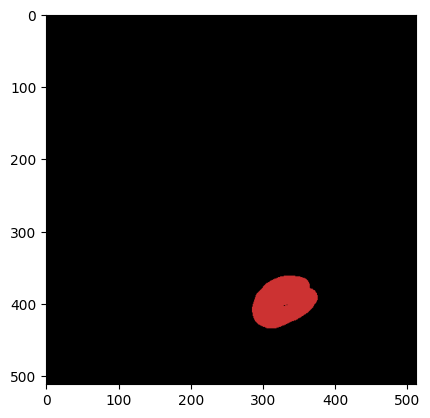

In [11]:
layer_dir = '/home/ubunto/Project/konglx/generate/diffusers/UI/layers0.png'
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the layer image
layer_img = Image.open(layer_dir)

# Convert the image to a numpy array
layer_arr = np.array(layer_img)
print(np.unique(layer_arr))
# Plot the image
plt.imshow(layer_arr)
plt.show()

In [12]:
import gradio as gr
import time
import numpy as np
import cv2

def saveimg(im):
    #print(im["layers"][0])
    background=im["background"]
    composite=im["composite"]
    background=cv2.cvtColor(background, cv2.COLOR_BGR2RGB )
    composite=cv2.cvtColor(composite, cv2.COLOR_BGR2RGB )
    cv2.imwrite("layers0.png",im["layers"][0])
    cv2.imwrite("background.png",background)
    cv2.imwrite("composite.png",composite)
    return gr.ImageMask(value=im,height=600), background

def loadimg(im):
    layers0=cv2.imread("layers0.png",-1)
    background=cv2.imread("background.png")
    composite=cv2.imread("composite.png")
    #layers0=cv2.cvtColor(layers0, cv2.COLOR_RGB2BGR, cv2.IMREAD_UNCHANGED )
    background=cv2.cvtColor(background, cv2.COLOR_RGB2BGR )
    composite=cv2.cvtColor(composite, cv2.COLOR_RGB2BGR )
    
    im["layers"][0]=layers0
    im["background"]=background
    im["composite"]=composite
    return gr.ImageMask(value=im,height=600), background

def upim(im_in,im):
    print(type(im_in))
    height, width, channels = im_in.shape[:3]
    im["background"]=im_in
    im["layers"][0]=np.zeros((height, width, 4), np.uint8)
    #im["layers"][1]=None

    print(f" shape:{im_in.shape}, ndim:{im_in.ndim}, size:{im_in.size}")
    return gr.ImageMask(value=im,height=600)
def getmask(im):
    im.save("i.png")
    #dst = Image.new('RGBA', (im.width + o_img.width, im.height))
    
with gr.Blocks() as demo:
    with gr.Tab("カウント"):
        with gr.Row():
            with gr.Column():
                im_in = gr.Image(sources="upload")
                uploadbtn = gr.Button("image upload")
            with gr.Column():    
                with gr.Row():
                    im = gr.ImageMask(height=600)
                with gr.Row():
                    savebtn = gr.Button("save")
                    loadbtn = gr.Button("load")
                with gr.Accordion():
                    with gr.Row():
                        im2 = gr.Image(height=600)
            uploadbtn.click(upim,[im_in,im],[im])
            savebtn.click(saveimg, outputs=[im, im2], inputs=im)
            
            loadbtn.click(loadimg, outputs=[im, im2], inputs=im)
    with gr.Tab("症例一覧"):
        with gr.Row():
            im3 = gr.Image(height=600)

if __name__ == "__main__":
    demo.queue()
    demo.launch(server_name="0.0.0.0",server_port=8044, root_path="/8044")


Running on local URL:  http://0.0.0.0:8044

To create a public link, set `share=True` in `launch()`.


<class 'numpy.ndarray'>
 shape:(512, 512, 3), ndim:3, size:786432


Traceback (most recent call last):
  File "/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/blocks.py", line 1935, in process_api
    result = await self.call_function(
  File "/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/gradio/blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-p